# ⌚️ DM&ML 2020 - Team Rolex

## 🖋 Authors
- Francis Ruckstuhl, 16-821-738
- Hanna Birbaum, 16-050-114
- Loïc Rouiller-Monay, 16-832-453

## 🕵️ Project description

Real or Not? NLP with Disaster Tweets: Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.


## 📝 Commits

### Best commit:

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [B.] Previous commits

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [C.] Progression of accuracies

<AxesSubplot:xlabel='commit_number', ylabel='accuracy'>

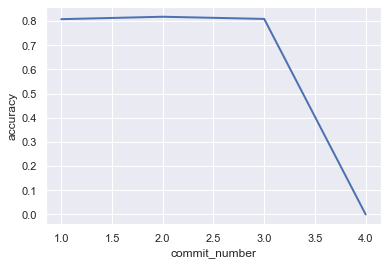

In [197]:
# /!\ You have to run Chapter 1. "libraries“ first before being able to plot the progression of accuracies
accuracy_progression = pd.read_csv('../documents/accuracy_progression.csv', sep=';')
sns.lineplot(x=accuracy_progression.commit_number, y=accuracy_progression.accuracy, linewidth=2)

# 📚 1. Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import spacy
from nltk.stem.snowball import SnowballStemmer
# load English language model of spacy
sp = spacy.load('en_core_web_sm')
import string
from spellchecker import SpellChecker
import pycountry
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from gensim.models.doc2vec import TaggedDocument

# 📂 2. Download data


## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

In [62]:
train = pd.read_csv('../data/training_data.csv')
test = pd.read_csv('../data/test_data.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [63]:
train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


## Features
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


# 🔬 3. Exploratory Data Analysis

## [A.] What is the baserate of the problem?

In [65]:
base_rate = train.target.value_counts().max()/len(train)
print(f'\nThe base rate is {base_rate}')


The base rate is 0.5719363313243703


## Target class distribution

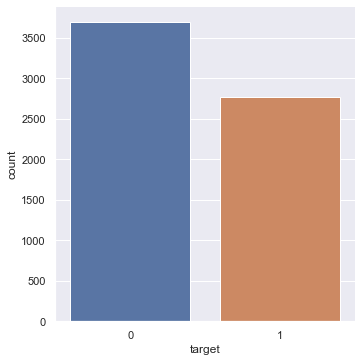

In [66]:
sns.catplot(x="target", kind="count", data=train);

## Missing values

In [67]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

It misses value in two features : keyword and location.

### Missing value in "keyword"

In [68]:
train.keyword.isnull().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

### Missing value in "location"

In [69]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

## Tweets length

### Number of characters

In [70]:
train["num_char"] = train["text"].apply(len)
test["num_char"] = test["text"].apply(len)

<AxesSubplot:xlabel='target', ylabel='num_char'>

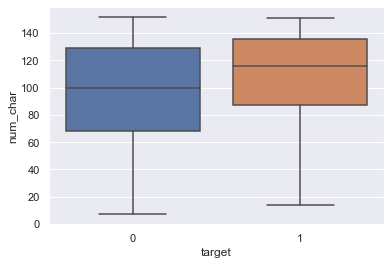

In [71]:
sns.boxplot(x='target', y='num_char', data=train)

##### Findings
Tweets about real disaster seems to be lengthier.

### Number of words

In [72]:
train["num_words"] = train["text"].apply(lambda x: len(x.split()))
test["num_words"] = test["text"].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='target', ylabel='num_words'>

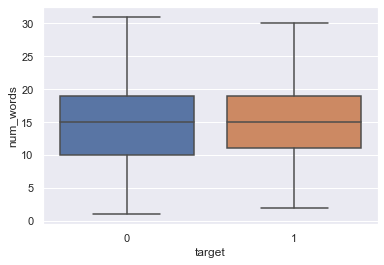

In [73]:
sns.boxplot(x='target', y='num_words', data=train)

##### Findings
Tweets about real disaster do not seem to have more words. Maybe it'll help to take this into consideration.

### Average word length

In [74]:
train["avg_word_length"] = train['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))
test["avg_word_length"] = test['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))

<AxesSubplot:xlabel='target', ylabel='avg_word_length'>

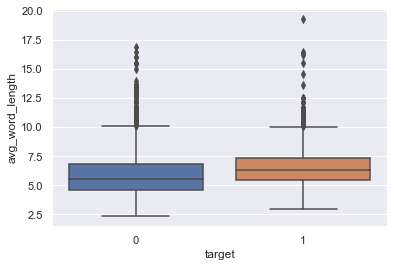

In [75]:
sns.boxplot(x='target', y='avg_word_length', data=train)

##### Findings
Tweets about real disaster seems to have lengtier average word length

### Number of hashtags in text

In [76]:
train['num_hashtags'] = train['text'].apply(lambda x: x.count('#'))
test['num_hashtags'] = test['text'].apply(lambda x: x.count('#'))

<AxesSubplot:xlabel='target', ylabel='num_hashtags'>

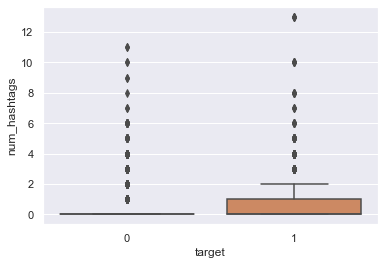

In [77]:
sns.boxplot(x='target', y='num_hashtags', data=train)

### Number of punctuation in tweets

In [78]:
punctuations = string.punctuation

def count_punctuation(text):
    count = 0
    for r in text:
        if r in punctuations:
            count += 1
    return count

In [79]:
train['num_punct'] = train['text'].apply(lambda x: count_punctuation(x))
test['num_punct'] = test['text'].apply(lambda x: count_punctuation(x))

<AxesSubplot:xlabel='target', ylabel='num_punct'>

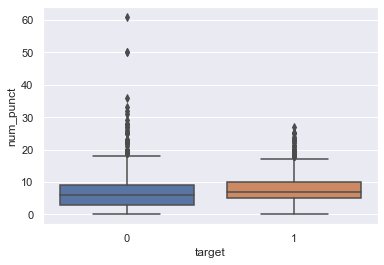

In [80]:
sns.boxplot(x='target', y='num_punct', data=train)

### Locate disasters

In [81]:
# Where do most disasters occur / where do disaster tweets come from? 
# Potential problem to take care of: USA and United States are separate; Different US States are also separate;
# train.loc[train["target"] == 1, ["location"]].value_counts()

# 🧹 4. Data cleaning

## Keywords

In [82]:
# remove '%20' from keyword feature
train.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))
test.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))

In [83]:
# check if NaN values in the keyword feature
print(train.keyword.isnull().any())
print(test.keyword.isnull().any())

False
False


In [84]:
# use pycountry in order to check if a country appears in the location
# if yes takes the country, else turn it to NaN
# with train and test data set

In [85]:
# train.location.apply(lambda x: print(x))

## Text

In [24]:
for word in 'This is a test'.split():
    print(word)

This
is
a
test


In [86]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

def count_punct(text):
    count = 0
    for r in text:
        if r in punctuations:
            count += 1
    return count

def separate_punct(text):
    temp = []
    for char in text:
        if char not in punctuations:
            temp.append(char)
        else:
            temp.append(' '+char)
    return ''.join(temp)

def clean_text(text):
    # remove unicode literals
    temp = text.encode('ascii',errors='ignore').decode('ascii')
    
    # remove &amp
    temp = temp.replace('&amp;', '')
    
    # remove urls
    temp = re.sub(r"http\S+", "", temp)
    
    # remove html
    temp = re.sub(r'<.*?>', "", temp)
    
    # remove hashtags
    temp = re.sub(r'#', "", temp)

    # remove people account with @
    temp = re.sub(r'@\S+', "", temp)
    
    # remove 'RT'
    temp = temp.replace('RT', '')
    
    # remove punctuation
    # temp = ''.join([ char for char in temp if char not in punctuations ])
    
    # separate punctuation
    # temp = separate_punct(temp)

    # remove "."
    temp.replace('.','')
    
    # lowercase
    temp = temp.lower()
    
    # spell checking
    spell = SpellChecker()
    temp_spellchecked = []
    for word in temp.split():
        temp_spellchecked.append(spell.correction(word))
        
    # stemming with nltk
    stemmer = SnowballStemmer(language='english')
    temp_stemmed = []
    for word in temp_spellchecked:
        temp_stemmed.append(stemmer.stem((word)))
    
    # Create spacy object
    temp = sp(' '.join(temp_stemmed))

    # Lemmatize each token and convert each token into lowercase
    temp = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in temp ]
    
    # Remove stop words 
    temp = [ word for word in temp if word not in stop_words  ]
    
    # lowercase
    temp = ' '.join(temp)
    
    return temp

In [ ]:
# clean text
train.text = train.text.apply(lambda x: clean_text(x))
test.text = test.text.apply(lambda x: clean_text(x))

In [ ]:
train.text.apply(lambda x: print(x))

## Location

In [11]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

# 🛠 [D.] 5. Feature Engineering

In [26]:
pycountry.countries.search_fuzzy('England')

[Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')]

In [27]:
# not good 

def location_to_country(location):
    temp = location.split(',')
    countries = list(pycountry.countries)
    
    for word in temp:
        for i in range(len(countries)):
            if (word.strip() in countries[i].alpha_2) or (word.strip() in countries[i].alpha_3) or (word.strip() in countries[i].name):
                return countries[i].name
    return 'Unknown'

train['country'] = train.location.apply(lambda x: location_to_country(str(x)))
train[['location', 'country']].head(60)

,location,country
0,USA,United States
1,NaN,Unknown
2,"Palm Beach County, FL",Falkland Islands (Malvinas)
3,USA,United States
4,Australia,Australia
5,Scotland,Unknown
6,New York City,Unknown
7,Multinational *****,Unknown
8,Los Angeles,Unknown
9,NaN,Unknown


## Text

In [ ]:
train

### Number of punctuation mult by number of characters

In [ ]:
train['num_punct_mult_num_char'] = train.num_char * train.num_punct
test['num_punct_mult_num_char'] = test.num_char * test.num_punct

In [ ]:
sns.boxplot(x='target', y='num_punct_mult_num_char', data=train)

### Number of punctuation divided by avgt word length

In [ ]:
train['num_punct_over_avg_word_length'] = train.num_punct / train.avg_word_length
test['num_punct_over_avg_word_length'] = test.num_punct / test.avg_word_length

In [ ]:
sns.boxplot(x='target', y='num_punct_over_avg_word_length', data=train)

# ⚙️ 6. Preprocessing

In [28]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    # numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove all word with less that 3 letters (remove noise)
    mytokens = [ word for word in mytokens if len(word)>2 ]

    # Return preprocessed list of tokens
    return mytokens

In [29]:
# Tokenize texts
processed_texts = []
for text in train.text:
    processed_text = spacy_tokenizer(text)
    processed_texts.append(processed_text)

# 🤖 7. Models

In [17]:
train = pd.read_csv('../data/training_data_spellchecked.csv')
test = pd.read_csv('../data/test_data_spellchecked.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv') 

# set index of dataframes
train = train.set_index('Unnamed: 0')
test = test.set_index('Unnamed: 0')

In [39]:
train.keyword = train.keyword.apply(lambda x: x.replace('%20', ' '))

In [40]:
train

,id,keyword,location,text,target,num_char,num_words,avg_word_length,num_hashtags
Unnamed: 0,,,,,,,,,
0,3738,destroyed,USA,black eye 9 space battle occur star a74 involv...,0,106,19,4.631579,0
1,853,bioterror,NaN,world feel long transport bioterror germ wake ...,0,106,15,6.066667,1
2,10540,windstorm,"Palm Beach County, FL",reality training train fall elevated track win...,1,105,12,7.833333,2
3,5988,hazardous,USA,taiwan grace expect large rock tree mud unstab...,1,133,19,6.052632,1
4,6328,hostage,Australia,new isis video isis threaten behead croatian h...,1,125,17,6.411765,1
...,...,...,...,...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,earthquake simo m 19 km e anchorage alaska tim...,1,135,17,7.000000,2
6467,3408,derail,NaN,totally agree 23 know birth control isi true w...,0,140,25,4.640000,0
6468,9794,trapped,NaN,hollywood movie trap miner release chile 33 ho...,1,136,17,7.058824,0


In [57]:
train.text = train.text.astype(str)
train.keyword = train.keyword.astype(str)
train.location = train.location.astype(str)

## Bag of Words (BOW)

In [85]:
# Using tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit_transform(train.text)

In [86]:
# Get feature names
feature_names = count.get_feature_names()

In [87]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [88]:
# additional features
train_full = pd.concat([processed_train, train[['num_char', 'num_hashtags', 'num_words', 'avg_word_length']]], axis=1)

In [89]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [36]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=2000, cv=3)

In [37]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

C:\Users\loicr\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


KeyboardInterrupt: 

In [38]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

AttributeError: 'LogisticRegressionCV' object has no attribute 'coef_'

## TF-IDF Representation

In [90]:
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2))

In [91]:
%%time
features = tfidf.fit_transform(train.text)
features_df = pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names()
)

Wall time: 510 ms


In [92]:
# Select features
X = features_df # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=707)

### Logistic Regression

In [93]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=5)

In [94]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

KeyboardInterrupt: 

In [95]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

AttributeError: 'LogisticRegressionCV' object has no attribute 'coef_'

### Neural network models

In [51]:
from sklearn.neural_network import MLPClassifier

In [52]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [53]:
%%time
# Fit model on training set
clf.fit(X_train, y_train)

Wall time: 1min 56s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [54]:
# Predictions
y_pred = clf.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7606


### Multiple documents

In [102]:
tfidf_vectorizer = TfidfVectorizer()

tf_train_data = pd.concat([train['text'], train['location'], train['keyword']])
tfidf_vectorizer.fit_transform(tf_train_data)

train['tf_idf_text'] = tfidf_vectorizer.transform(train['text'])
train['tf_idf_location'] = tfidf_vectorizer.transform(train['location'])
train['tf_idf_keyword'] = tfidf_vectorizer.transform(train['keyword'])

data_for_model = train[['tf_idf_text', 'tf_idf_location', 'tf_idf_keyword']]

X = data_for_model[['tf_idf_text', 'tf_idf_location', 'tf_idf_keyword']]
y = train['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=707)

In [104]:
X_train.tf_idf_text.to_array()

AttributeError: 'Series' object has no attribute 'to_array'

In [82]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

classifier.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

In [ ]:
# Predictions
y_pred = clf.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

## Decision tree

In [73]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = DecisionTreeClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

CPU times: user 1min 14s, sys: 1.74 s, total: 1min 16s
Wall time: 1min 41s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', DecisionTreeClassifier())])

In [74]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7205


## Classification using Doc2Vec and Logistic Regression

In [37]:
sample_tagged = train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

NameError: name 'spacy_tokenizer' is not defined

In [38]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

NameError: name 'sample_tagged' is not defined

In [ ]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=1, vector_size=100, negative=5, hs=0, min_count=1, sample=0, workers=cores, epoch=500)
model_dbow.build_vocab([x for x in train_tagged.values])

In [ ]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [50]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=300)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# Each document (i.e. complaint) is now a vector in the space of 30 dimentions.
# Similar complaints should have similar vector representation.

In [51]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegressionCV(max_iter=3000, cv=3, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegressionCV(cv=3, max_iter=3000)

In [52]:
# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7876


## Classification using Doc2Vec, more features and Logistic Regression

# 🏆 8. Submission

## BOW

In [391]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit(train.text)
bow = count.transform(train.text)

In [392]:
# Get feature names
feature_names = count.get_feature_names()

In [393]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [397]:
train_full = pd.concat([train[['num_char', 'avg_word_length', 'num_punct', 'num_punct_mult_num_char', 'num_punct_over_avg_word_length']], processed_train], axis=1)

In [398]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

In [399]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=6000, cv=5)

In [ ]:
%%time
# Fit model on training set
classifier.fit(X, y)

In [ ]:
bow_test = count.transform(test.text)
# Get feature names
feature_names_test = count.get_feature_names()

In [ ]:
# Show as a dataframe
processed_test = pd.DataFrame(
    bow_test.todense(),
    columns=feature_names_test
    )

In [ ]:
test_full = pd.concat([test[['num_char', 'avg_word_length', 'num_punct', 'num_punct_mult_num_char', 'num_punct_over_avg_word_length']], processed_test], axis=1)

In [ ]:
# Predictions

y_pred = classifier.predict(test_full)

## TF IDF

In [ ]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words]

    # Return preprocessed list of tokens
    return mytokens

In [ ]:
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=spacy_tokenizer)

In [ ]:
%%time
# fit tfidf
tfidf.fit(train.text)

In [ ]:
%%time
features_train = tfidf.transform(train.text)
features_train_df = pd.DataFrame(
    features_train.todense(),
    columns=tfidf.get_feature_names()
)

features_test = tfidf.transform(train.text)
features_test_df = pd.DataFrame(
    features_test.todense(),
    columns=tfidf.get_feature_names()
)

In [28]:
train_full = pd.concat([features_train_df, train[['num_char', 'avg_word_length', 'num_punct']]], axis=1)
test_full = pd.concat([features_test_df, test[['num_char', 'avg_word_length', 'num_punct']]], axis=1)

In [30]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

In [29]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=3000, cv=5)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001A08775D040>)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [31]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [ ]:
y_pred = classifier.predict(test_full)

## Export submission

In [ ]:
sample_submission.target = y_pred

In [ ]:
sample_submission.target.value_counts()

In [ ]:
sample_submission.to_csv('submission-004.csv', index=False)

In [ ]:
test = pd.read_csv('submission-004.csv')

In [ ]:
test.target.value_counts()